In [1]:
import pandas as pd
import numpy as np

from tabpfn.plot_code.cd_plot_code import cd_evaluation
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

varies_over_time = ['XGBoost', 'RF', 'MLP', 'KNN', 'LogReg']

warnings.simplefilter("ignore", FutureWarning)

valid_results = pd.read_csv("results_valid_1213.csv", index_col=0)
valid_results.model.unique()

array(['KNN', 'RF', 'XGBoost', 'LogReg', 'MLP', 'TabPFN (Hollmann)',
       'MLP-Distill', 'TabPFN (ours)', 'MotherNet'], dtype=object)

In [2]:
test_results = pd.read_csv("results_test_1213.csv", index_col=0)
test_results.model.unique()

array(['KNN', 'RF', 'XGBoost', 'LogReg', 'MLP', 'MLP-Distill',
       'MotherNet', 'TabPFN (Hollmann)', 'TabPFN (ours)'], dtype=object)

In [3]:
assert set(test_results.model.unique()) == set(valid_results.model.unique())

In [4]:
all_models = test_results.model.unique()
color_palette = sns.color_palette(n_colors=len(all_models))
color_mapping = dict(zip(all_models, color_palette))

In [5]:
def get_best_over_time(results):
    average_over_splits = results.groupby(["dataset", "model", "max_time"])[["mean_metric", "fit_time", "inference_time"]].mean().reset_index()
    best_tuned = average_over_splits[average_over_splits.max_time == average_over_splits.max_time.max()]
    untuned = average_over_splits[~average_over_splits.model.isin(best_tuned.model.unique())]
    return pd.concat([best_tuned, untuned])

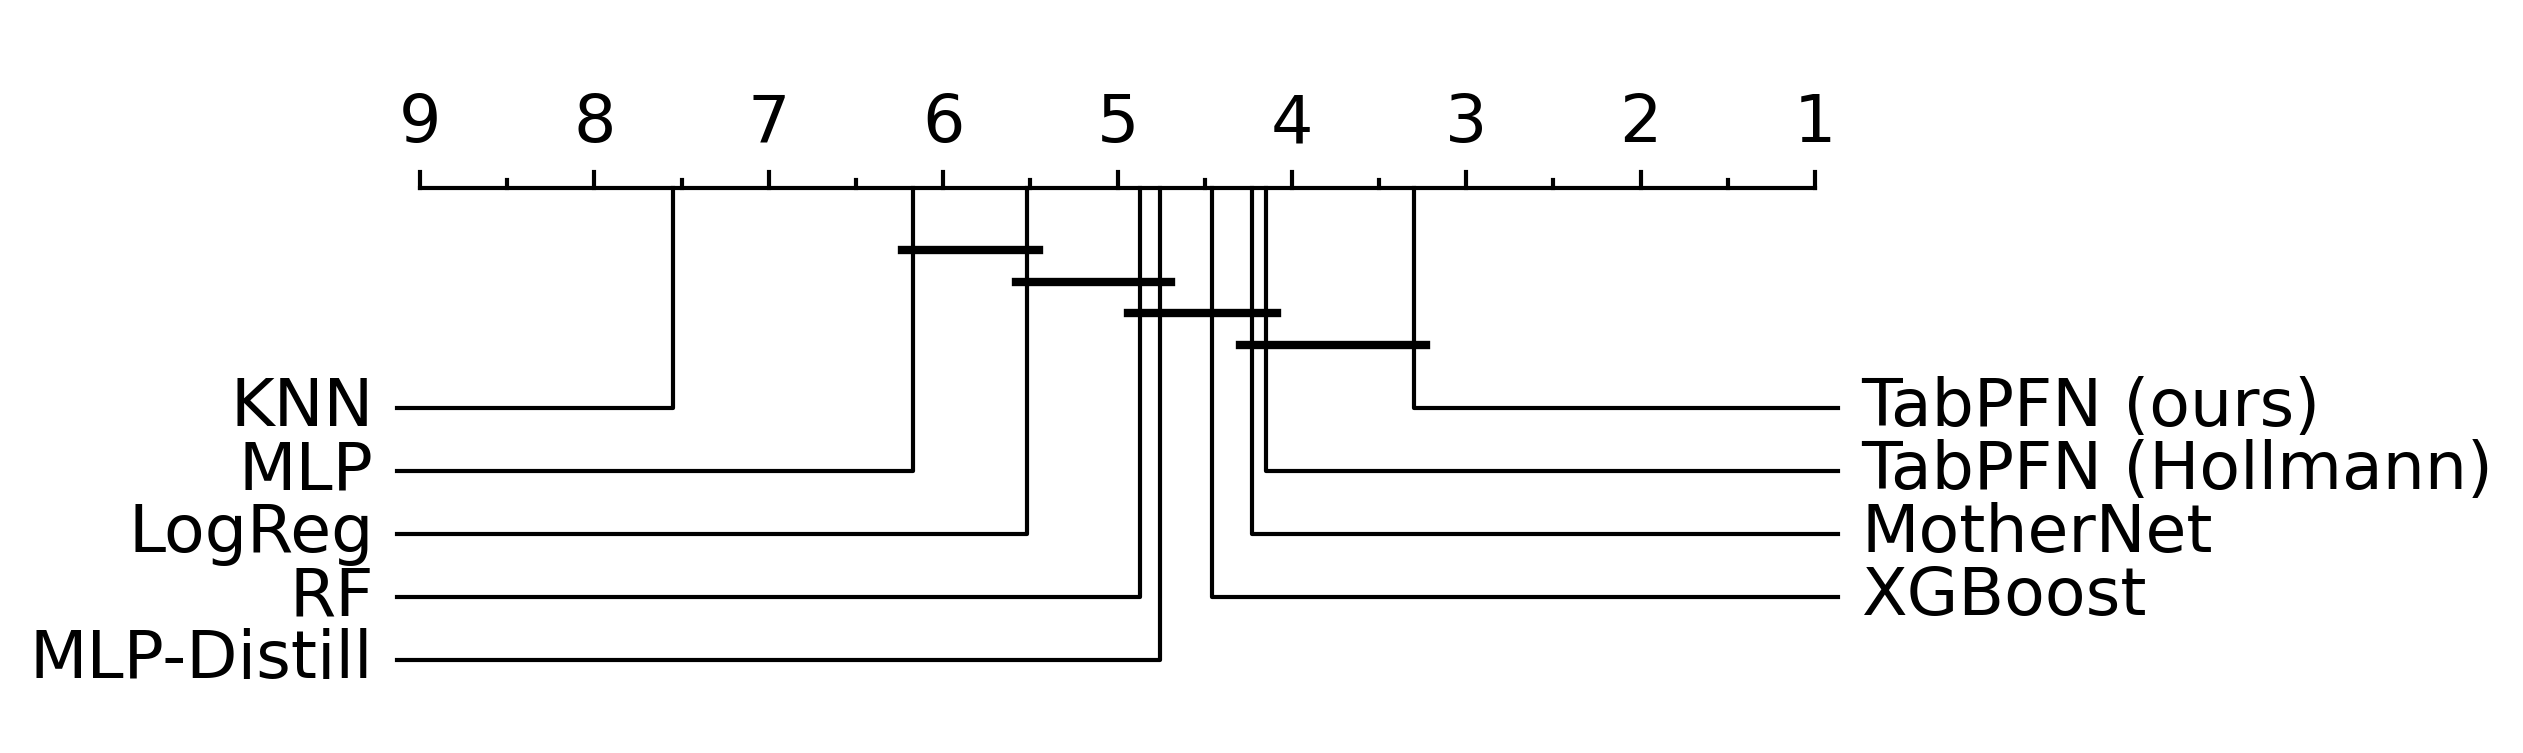

In [38]:
plt.figure(figsize=(8, 3), dpi=300)
combined_best_valid = get_best_over_time(valid_results)
pivoted_for_cd = combined_best_valid.pivot(index="dataset", columns="model", values="mean_metric")
_ = cd_evaluation(pivoted_for_cd, maximize_metric=True, ax=plt.gca())
plt.savefig("figures/cd_diagram_validation.pdf", bbox_inches="tight")

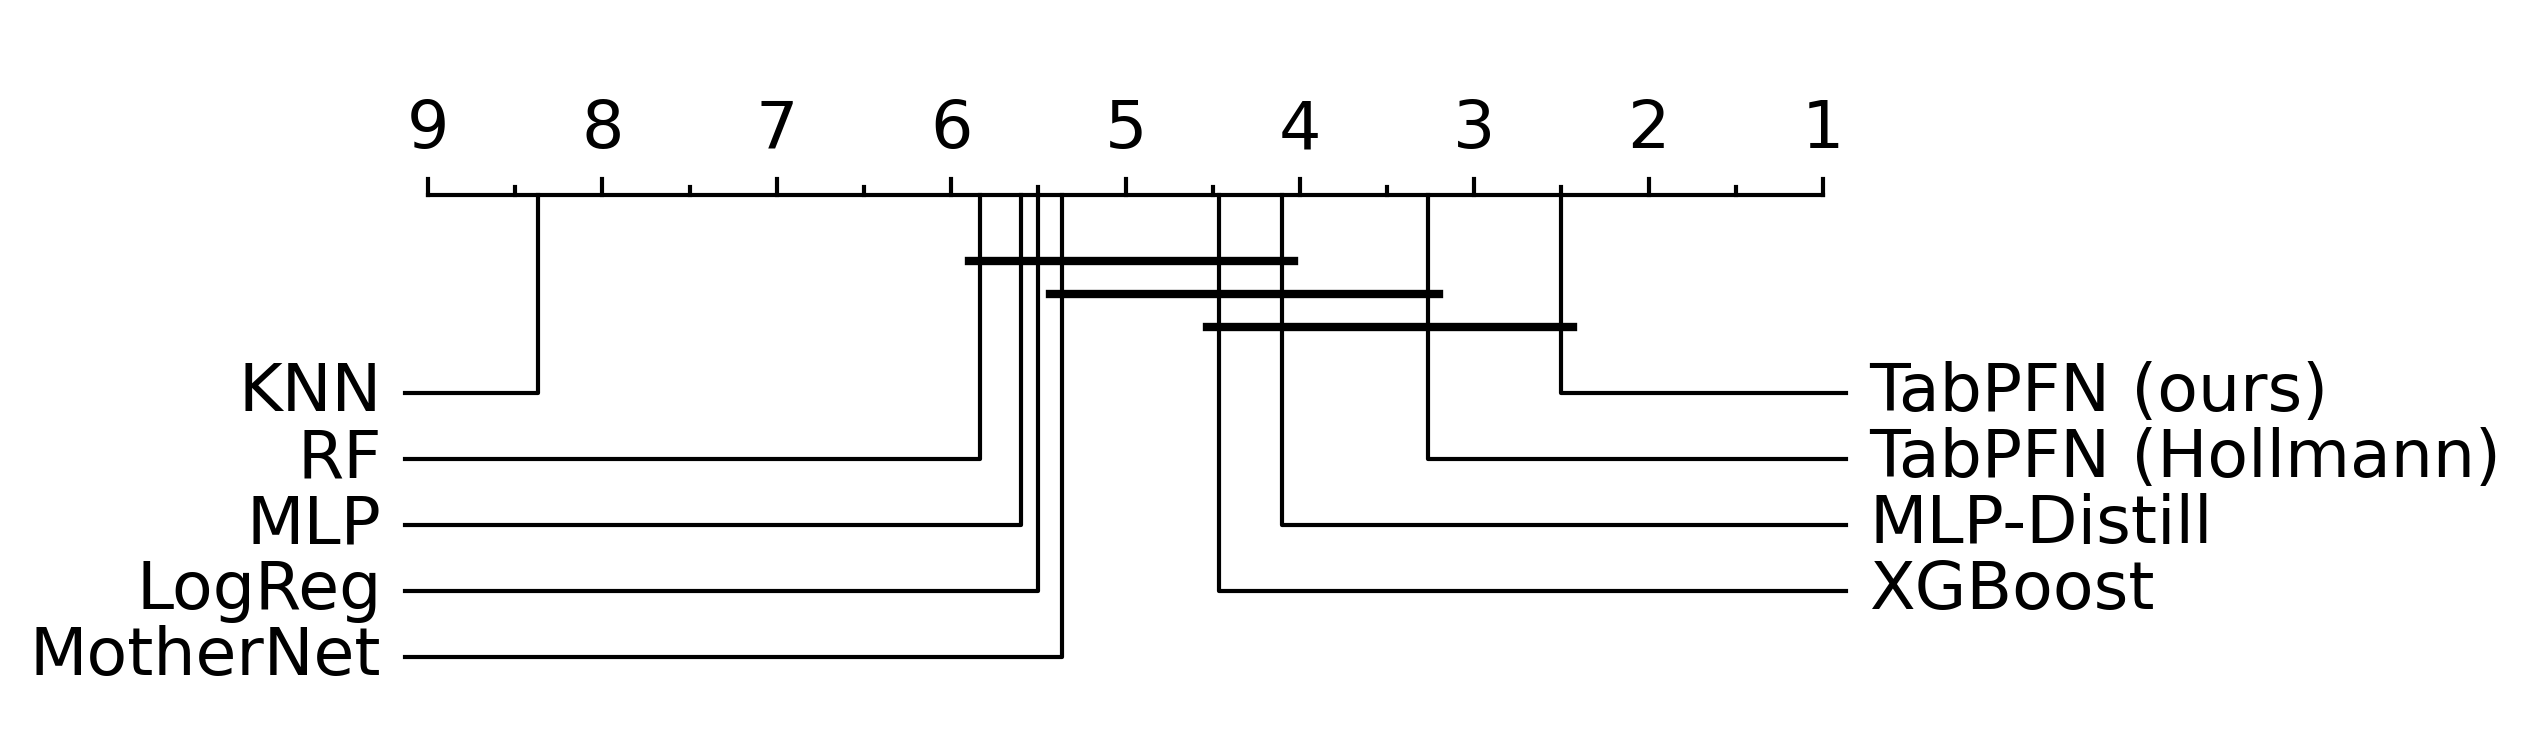

In [39]:
plt.figure(figsize=(8, 3), dpi=300)
combined_best_test = get_best_over_time(test_results)
pivoted_for_cd = combined_best_test.pivot(index="dataset", columns="model", values="mean_metric")
_ = cd_evaluation(pivoted_for_cd, maximize_metric=True, ax=plt.gca())
plt.savefig("figures/cd_diagram_test.pdf", bbox_inches="tight")

In [12]:
def compare_splits(results):
    compare_splits_over_time = results.groupby(["model", "split", "max_time"])['mean_metric'].mean().reset_index()
    compare_splits_varies = compare_splits_over_time[compare_splits_over_time.model.isin(varies_over_time)]
    compare_splits_fixed = compare_splits_over_time[~compare_splits_over_time.model.isin(varies_over_time)]
    compare_splits_varies_last = compare_splits_varies[compare_splits_varies.max_time == compare_splits_varies.max_time.max()]
    return compare_splits_over_time, pd.concat([compare_splits_fixed, compare_splits_varies_last])

In [13]:
compare_splits_over_time_valid, compare_splits_valid = compare_splits(valid_results)
compare_splits_over_time_test, compare_splits_test = compare_splits(test_results)

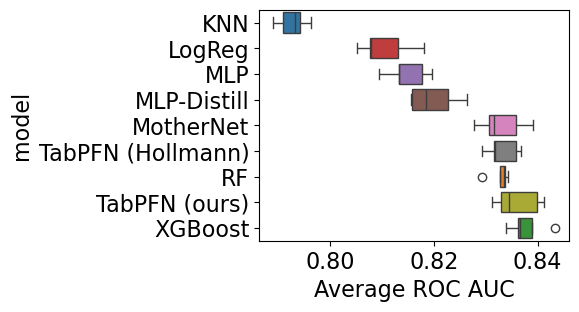

In [37]:
plt.figure(figsize=(4, 3))
order = compare_splits_valid.groupby("model").median("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=compare_splits_valid, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
plt.xlabel("Average ROC AUC")
plt.savefig("figures/mean_roc_auc_validation.pdf", dpi=300, bbox_inches="tight")

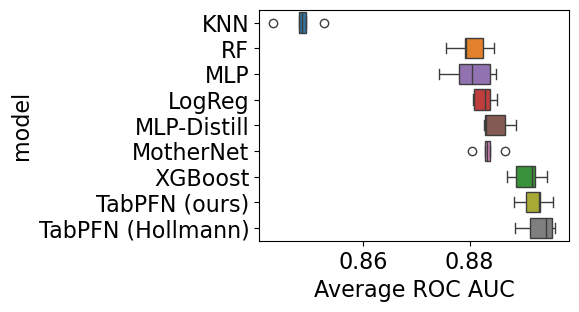

In [15]:
plt.figure(figsize=(4, 3))
order = compare_splits_test.groupby("model").median("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=compare_splits_test, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
plt.xlabel("Average ROC AUC")
plt.savefig("figures/mean_roc_auc_test.pdf", dpi=300, bbox_inches="tight")

In [31]:
def normalize_metric(results):
    dataset_min_max = results.groupby("dataset").mean_metric.agg(["min", "max"])
    results_normalized = results.merge(dataset_min_max, on="dataset")
    results_normalized['mean_metric'] = (results_normalized['mean_metric'] - results_normalized['min']) / (results_normalized['max'] - results_normalized['min'])
    return results_normalized

In [41]:
compare_splits_over_time_valid_normalized, compare_splits_valid_normalized = compare_splits(normalize_metric(valid_results))
compare_splits_over_time_test_normalized, compare_splits_test_normalized = compare_splits(normalize_metric(test_results))

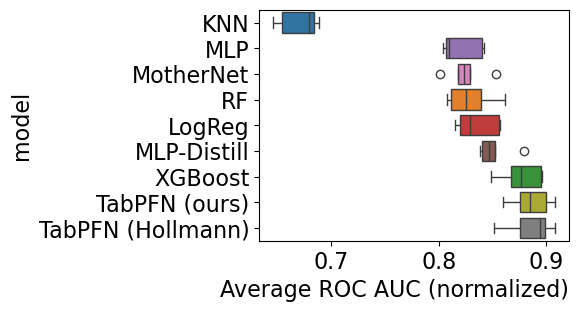

In [35]:
plt.figure(figsize=(4, 3))
order = compare_splits_test_normalized.groupby("model").median("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=compare_splits_test_normalized, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
plt.xlabel("Average ROC AUC (normalized)", loc="right")
plt.savefig("figures/mean_roc_auc_test_normalized.pdf", dpi=300, bbox_inches="tight")

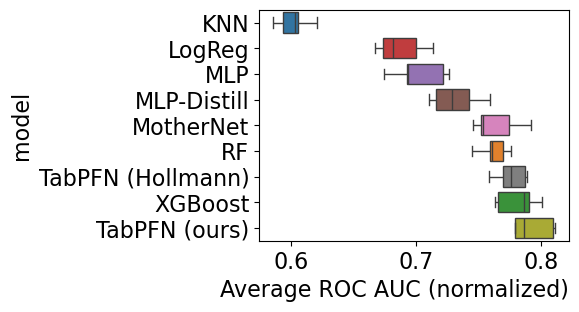

In [36]:
plt.figure(figsize=(4, 3))
order = compare_splits_valid_normalized.groupby("model").median("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=compare_splits_valid_normalized, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
plt.xlabel("Average ROC AUC (normalized)", loc="right")
plt.savefig("figures/mean_roc_auc_valid_normalized.pdf", dpi=300, bbox_inches="tight")

In [ ]:
test_set_roc_auc

In [50]:
compare_splits_fixed.model.unique()

array(['MLP-Distill', 'MotherNet', 'TabPFN (Hollmann)', 'TabPFN (ours)'],
      dtype=object)

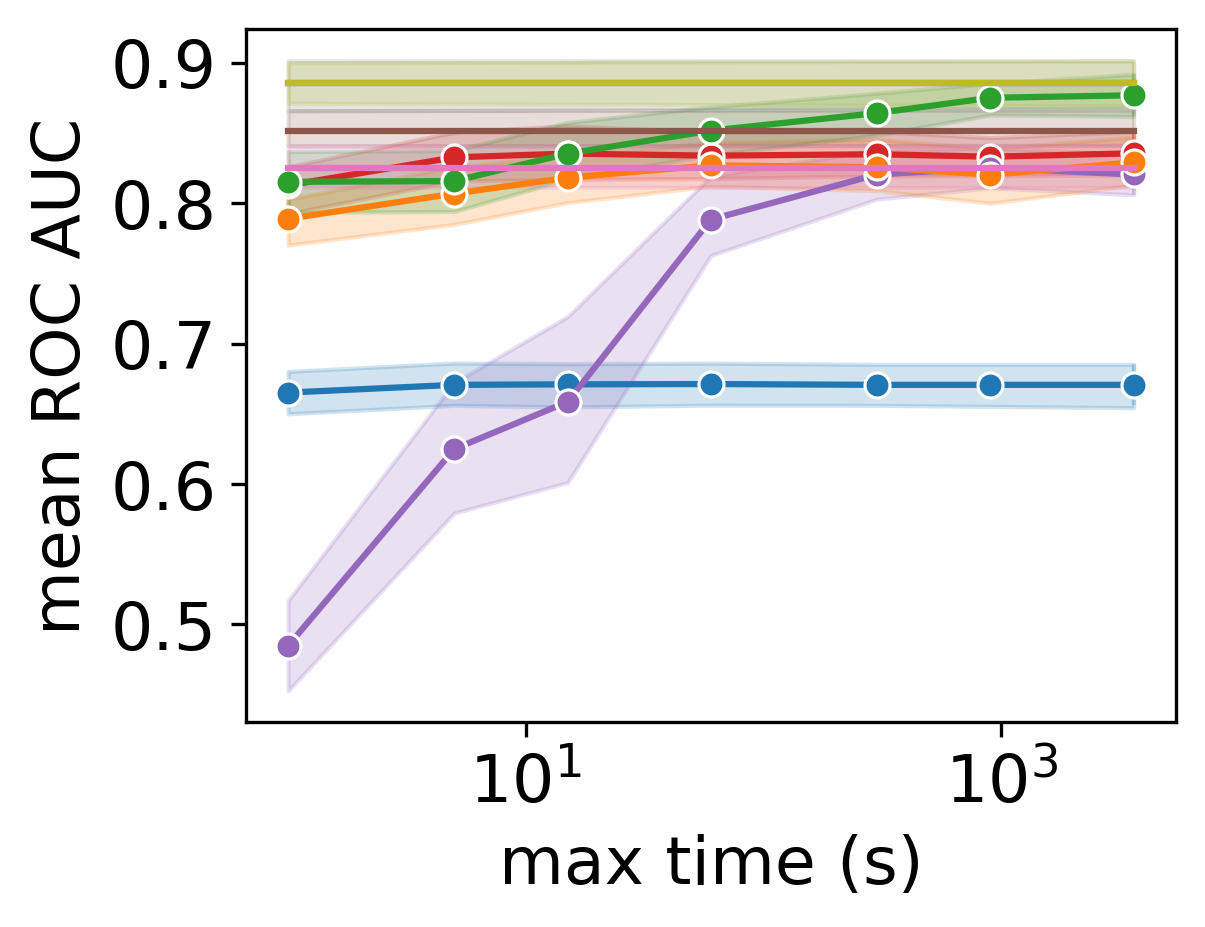

In [55]:
plt.figure(figsize=(4, 3), dpi=300)

compare_splits_varies = compare_splits_over_time_test_normalized[compare_splits_over_time_test_normalized.model.isin(varies_over_time)]
compare_splits_fixed = compare_splits_over_time_test_normalized[~compare_splits_over_time_test_normalized.model.isin(varies_over_time)]


ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model",  marker="o", palette=color_mapping)

compare_splits_fixed_dummy = compare_splits_test_normalized.copy()
compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
              x="max_time", y="mean_metric", hue="model", ax=ax, palette=color_mapping)
plt.xscale("log")
legend = plt.legend(loc=(1.1 , .3))
#legend = ax.get_legend()
legend.remove()
#ax.set_ylim(0.85, 0.90)
ax.set_ylabel("mean ROC AUC")
ax.set_xlabel("max time (s)")
plt.savefig("figures/mean_auc_over_time_test_normalized.pdf", bbox_inches="tight")

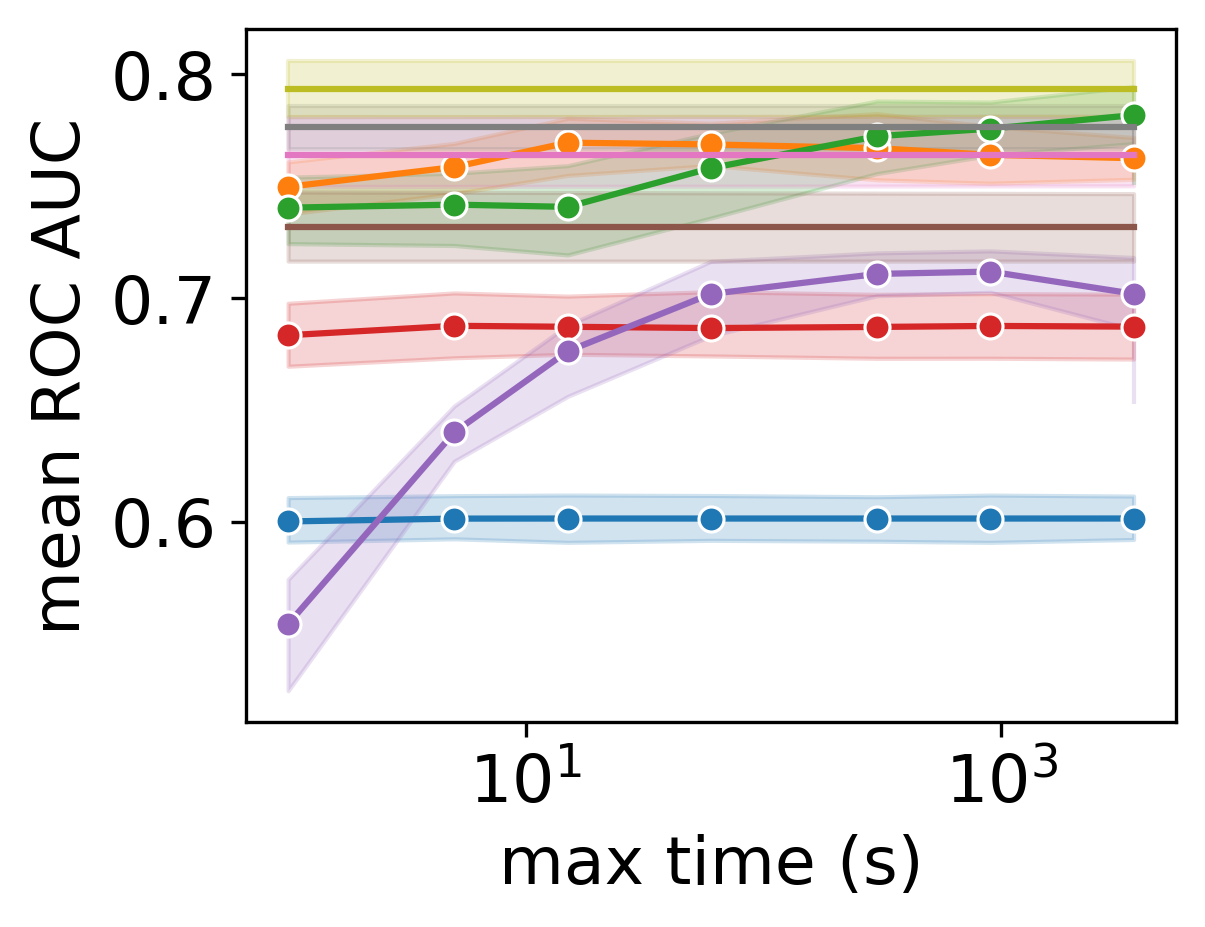

In [48]:
plt.figure(figsize=(4, 3), dpi=300)

compare_splits_varies = compare_splits_over_time_valid_normalized[compare_splits_over_time_valid_normalized.model.isin(varies_over_time)]
compare_splits_fixed = compare_splits_over_time_valid_normalized[~compare_splits_over_time_valid_normalized.model.isin(varies_over_time)]


ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model",  marker="o", palette=color_mapping)

compare_splits_fixed_dummy = compare_splits_over_time_valid_normalized.copy()
compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
              x="max_time", y="mean_metric", hue="model", ax=ax, palette=color_mapping)
plt.xscale("log")
#legend = plt.legend(loc=(1.1 , .3))
legend = ax.get_legend()
legend.remove()
#ax.set_ylim(0.85, 0.90)
ax.set_ylabel("mean ROC AUC")
ax.set_xlabel("max time (s)")
plt.savefig("figures/mean_auc_over_time_valid_normalized.pdf", bbox_inches="tight")